Visualizing Missingness

/var/folders/mn/x1lsf_0j0dl4sxlkkmh0q5kr0000gn/T/ipykernel_79263/3819479988.py:6: DtypeWarning: Columns (10404) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main2_cleaned = pd.read_csv('df_main2_cleaned.csv')


Overall missingness in features: 99.10%
Number of features with any missingness: 10400 out of 10400


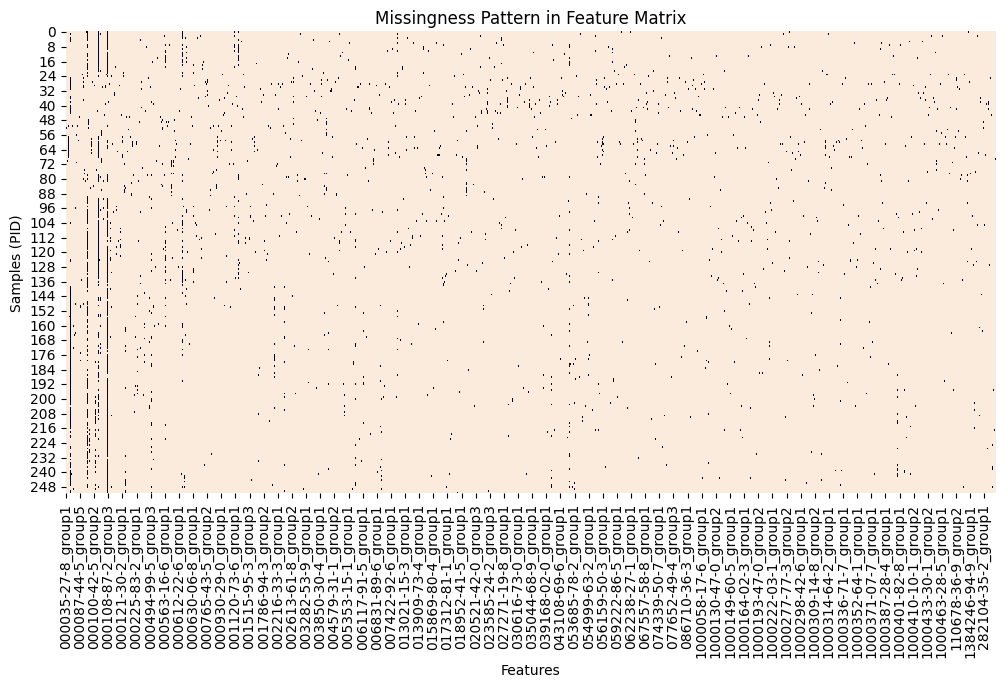

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
df_main2_cleaned = pd.read_csv('df_main2_cleaned.csv')

# Excluding demos
feature_cols = [col for col in df_main2_cleaned.columns if col not in ['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']]
# dtype issue correction. It will still throw a warning, but the line below resolves this
df_main2_cleaned[feature_cols] = df_main2_cleaned[feature_cols].apply(pd.to_numeric, errors='coerce')


# How much is missing
missing_perc = df_main2_cleaned[feature_cols].isnull().mean().mean() * 100
print(f"Overall missingness in features: {missing_perc:.2f}%")

# How many features are missing
features_with_missing = df_main2_cleaned[feature_cols].isnull().any().sum()
print(f"Number of features with any missingness: {features_with_missing} out of {len(feature_cols)}")

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_main2_cleaned[feature_cols].isnull(), cbar=False)
plt.title('Missingness Pattern in Feature Matrix')
plt.xlabel('Features')
plt.ylabel('Samples (PID)')
plt.show()

In [9]:
# Filter to keep only features present >=10% of samples
min_present = len(df_main2_cleaned) * 0.10
filtered_features = [col for col in feature_cols if df_main2_cleaned[col].notnull().sum() >= min_present]
print(f"Features retained after filtering: {len(filtered_features)}")
df_main2_clean_filter = df_main2_cleaned[filtered_features]

Features retained after filtering: 82


This is a huge drop in features, but not suprising. Dropping from 10,400 to 82 seems reasonable as this is exhalled VOCs.

**NOTE:** Unable to use BaylorEdPsych package for Little's MCAR does not work with current versions of R and is a noted grevience in the community. The same goes for running QRILC with the imputeLCMD package. Packages for R 4.4 have not been udpated which is why they are not working. 

Using R 3.6.3 in a Docker to use imputeLCMD package. RF was attempted using the MissForest algorithm (Stekhoven & Bühlmann, 2012) implemented in R (v4.4.0) via the missForest package, but was decided inapropriate given the missingness nature of this GCMS data being NCAR.  **WRITE THIS UP NICER**

In [3]:
# Exporting df for use in Docker image
df_main2_clean_filter.to_csv("df_to_impute.csv", index=False)  # <- place this in same folder as the Docker

**NOTE** This is where the R Docker script should be run

In [19]:
# Importing df from R post imputation with imputeLCMD package
imputed = pd.read_csv("imputed_output.csv")  # <- will need to copy this from the Docker folder to the Jupyter Area

# R named the CAS-RT Groups differently. Replacing original style:
imputed.columns = df_main2_clean_filter.columns

# pulling PID and demographic columns back in from df_main2_cleaned
df_main3 = pd.concat([
    df_main2_cleaned[['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']].reset_index(drop=True),
    imputed
], axis=1)

**NOTE TO SELF** we skipped TIC because they already should have been TIC'd before. 

Running df_main3.describe() confirms this

In [20]:
df_main3.describe()  # QC step to confirm TIC already occured

,Age,BMI,000067-64-1_group2,000067-68-5_group1,000074-95-3_group1,000074-97-5_group1,000077-68-9_group1,000078-79-5_group2,000078-93-3_group1,000086-73-7_group1,...,052195-40-1_group3,054446-78-5_group1,063521-76-6_group3,095798-15-5_group1,1000132-10-9_group2,1000308-17-8_group1,1000309-13-0_group1,1000386-40-2_group1,1000401-12-0_group1,1000417-00-6_group1
count,113.000000,113.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,36.336283,22.370555,0.275787,-0.119879,-0.034430,0.631811,0.085843,-0.165834,-0.077160,-0.033821,...,-0.399691,-0.153741,-0.186016,-0.377652,-0.018682,-0.138243,-0.334134,-0.342706,-0.083707,-0.117430
std,11.799372,4.536496,0.307686,0.162920,0.070811,1.052623,0.155679,0.682806,0.135761,0.036550,...,0.309064,0.220880,0.186329,0.720387,0.053830,0.124259,0.370241,0.298355,0.127247,0.117112
min,18.000000,13.714286,-0.407438,-0.501783,-0.189631,-0.708318,-0.272159,-0.933073,-0.399356,-0.119953,...,-0.891648,-0.622642,-0.629033,-0.968855,-0.159672,-0.430189,-0.886233,-0.907390,-0.422894,-0.378750
25%,27.000000,19.531250,0.038266,-0.238589,-0.084219,-0.127860,-0.019096,-0.611096,-0.173965,-0.061520,...,-0.639065,-0.311624,-0.313893,-0.823569,-0.053669,-0.234965,-0.599477,-0.560177,-0.170670,-0.203658
50%,33.000000,21.773842,0.210150,-0.129684,-0.033806,0.161950,0.085050,-0.367300,-0.094863,-0.033541,...,-0.463255,-0.185904,-0.218451,-0.604655,-0.019203,-0.154610,-0.418882,-0.404528,-0.088889,-0.133070
75%,46.000000,24.464602,0.511950,-0.009237,0.014880,1.361150,0.171925,0.063300,0.009426,-0.009410,...,-0.255358,-0.032069,-0.066617,-0.235511,0.016710,-0.049024,-0.182667,-0.202328,-0.000462,-0.047635
max,65.000000,38.514057,1.049000,0.351500,0.154200,6.480900,0.792200,2.956400,0.637400,0.080800,...,1.515500,0.790700,0.355700,3.918500,0.123300,0.262400,1.393500,0.907900,0.267300,0.213800


**Z-Scoring data**

Z-scored feature means (should be ~0):000067-64-1_group2    -9.692423e-17
000067-68-5_group1     1.321694e-17
000074-95-3_group1    -2.819614e-17
000074-97-5_group1    -1.127846e-16
000077-68-9_group1    -8.458842e-17
                           ...     
1000308-17-8_group1   -5.639228e-17
1000309-13-0_group1   -7.049035e-17
1000386-40-2_group1    1.409807e-16
1000401-12-0_group1   -9.868649e-17
1000417-00-6_group1   -4.229421e-17
Length: 82, dtype: float64 

Z-scored feature std devs (should be ~1): 000067-64-1_group2     1.00199
000067-68-5_group1     1.00199
000074-95-3_group1     1.00199
000074-97-5_group1     1.00199
000077-68-9_group1     1.00199
                        ...   
1000308-17-8_group1    1.00199
1000309-13-0_group1    1.00199
1000386-40-2_group1    1.00199
1000401-12-0_group1    1.00199
1000417-00-6_group1    1.00199
Length: 82, dtype: float64 



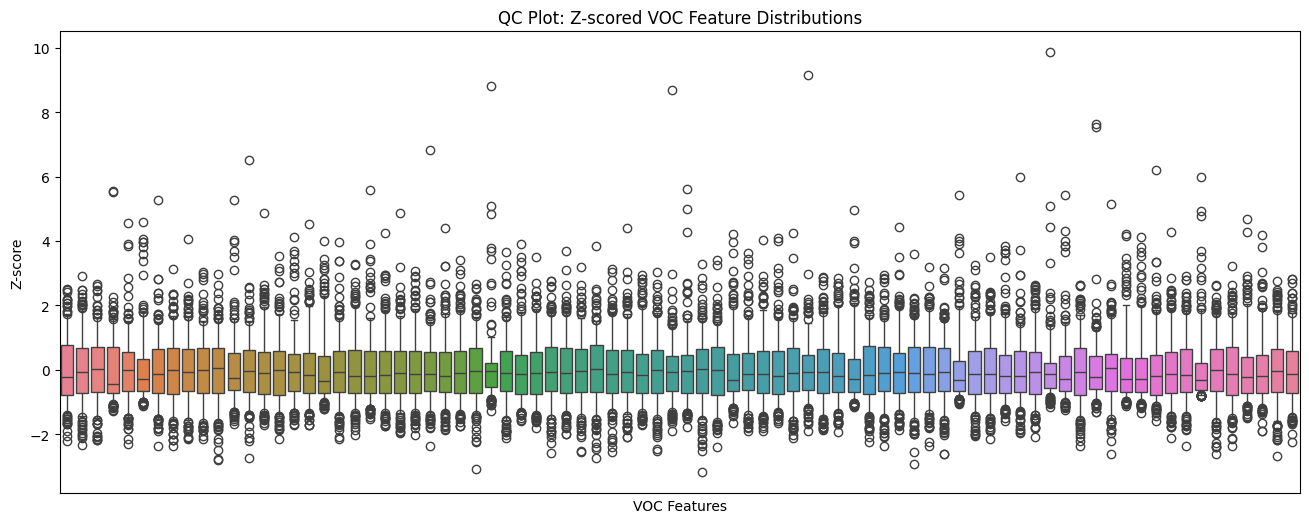

In [21]:
from sklearn.preprocessing import StandardScaler

# Extract VOC feature columns
feature_cols = df_main2_clean_filter.columns  # same 82 features

scaler = StandardScaler()
df_main3_z = df_main3.copy()
df_main3_z[feature_cols] = scaler.fit_transform(df_main3[feature_cols])

# QC
print(f"Z-scored feature means (should be ~0):{df_main3_z[feature_cols].mean()} \n")
print(f"Z-scored feature std devs (should be ~1): {df_main3_z[feature_cols].std()} \n")

# Boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_main3_z[feature_cols], whis=[5, 95])
plt.title('QC Plot: Z-scored VOC Feature Distributions')
plt.xlabel('VOC Features')
plt.ylabel('Z-score')
plt.xticks([], [])  # x-axis labels hidden for clarity bc so many features
plt.show()

When looking at the above plot...
* no one feature stands out more than another
* Most are centered around 0
* IQR mostly between +/- 1
* Outliers are both above and below which seems to make sense given variability of breath based VOCs

**QC checks out, normalization worked**

In [27]:
# switching data into 0 and 1 format
df_main3_z['TB Status'] = df_main3_z['TB Status'].map({'Negative': 0, 'Positive': 1})
df_main3_z['HIV Status'] = df_main3_z['HIV Status'].map({'Negative': 0, 'Positive': 1})
# saving
df_main3_z.to_csv('df_main_normalized.csv', index=False)